# `20180814a` - Testing interleaved acqs for a tentative 128Msps

In [1]:
#!/usr/bin/python
import spidev
#import RPi.GPIO as GPIO
import time
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import json
import time
from pyUn0 import *
%matplotlib inline

Not loading RPi.GPIO as not on RPi


In [2]:
x = us_spi()
x.JSON["firmware_version"]="e_un0"
x.JSON["experiment"]["id"] = "20180814a"
x.JSON["experiment"]["description"]="Testing if the lib works"
x.JSON["experiment"]["probe"]="piezo"
x.JSON["experiment"]["target"] = "a reflector few cms away"
x.JSON["V"]="48"
x.JSON["N"] = 1 # Experiment ID

In [3]:
x.init()                                    # Inits the FPGA

Curve = x.CreateDACCurve(300,900,True)[0]   # Sets the DAC, 50mV to 850mv

pyUn0.py:149: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(CS_FLASH,GPIO.OUT)
pyUn0.py:152: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(PRESET,GPIO.OUT)


Reset GPIO 23 - Low 1s
Reset GPIO 23 - High 0.2s
spi.cshigh is False
spi mode is 1
spi maxspeed is 2000000hz
Setting up the DAC


In [10]:
x.JSON["N"] = 1 

In [26]:
x.setNLines(1)				            # Setting the number of lines
x.setMultiLines(False)				        # Multi lines acquisition	
x.setMsps(0) 					            # Acquisition Freq
for k in range(10):
    A = x.setTimings(200,100,2000,25000+5*k,105000)	# Settings the series of pulses
    #print A
    # Do the acquisition
    x.JSON["data"] = x.doAcquisition()
    x.JSON["N"] = x.JSON["N"] + 1 

Number of lines: 1
Doing a single line
Acquisition frequency set at 64.0 Msps
Pulse width: 200  ns --  0x14
Pulses delay: 300  ns --  0x1e
Poff: 2300  ns --  0x0 0xe6
Delay between: 25000 ns --  0xc 0x80
Acquisition length:  105000 ns --  0x34 0x80
setPulseTrain Lacq 105000
NAcq = 5120
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
Took 1.24 seconds to transfer.
for 10242 transfers of data
20180813a-1.json: file saved.
Pulse width: 200  ns --  0x14
Pulses delay: 300  ns --  0x1e
Poff: 2300  ns --  0x0 0xe6
Delay between: 25000 ns --  0xc 0x80
Acquisition length:  105000 ns --  0x34 0x80
setPulseTrain Lacq 105000
NAcq = 5056
0%
9%
19%
29%
39%
49%
59%
69%
79%
89%
99%
Took 1.22 seconds to transfer.
for 10114 transfers of data
20180813a-2.json: file saved.
Pulse width: 200  ns --  0x14
Pulses delay: 300  ns --  0x1e
Poff: 2300  ns --  0x0 0xe6
Delay between: 25007 ns --  0xc 0x81
Acquisition length:  105000 ns --  0x34 0x80
setPulseTrain Lacq 105000
NAcq = 5056
0%
9%
19%
29%
39%
49%
59%
69%
7

# Let's open this data

Data acquired
133
Data acquired
132


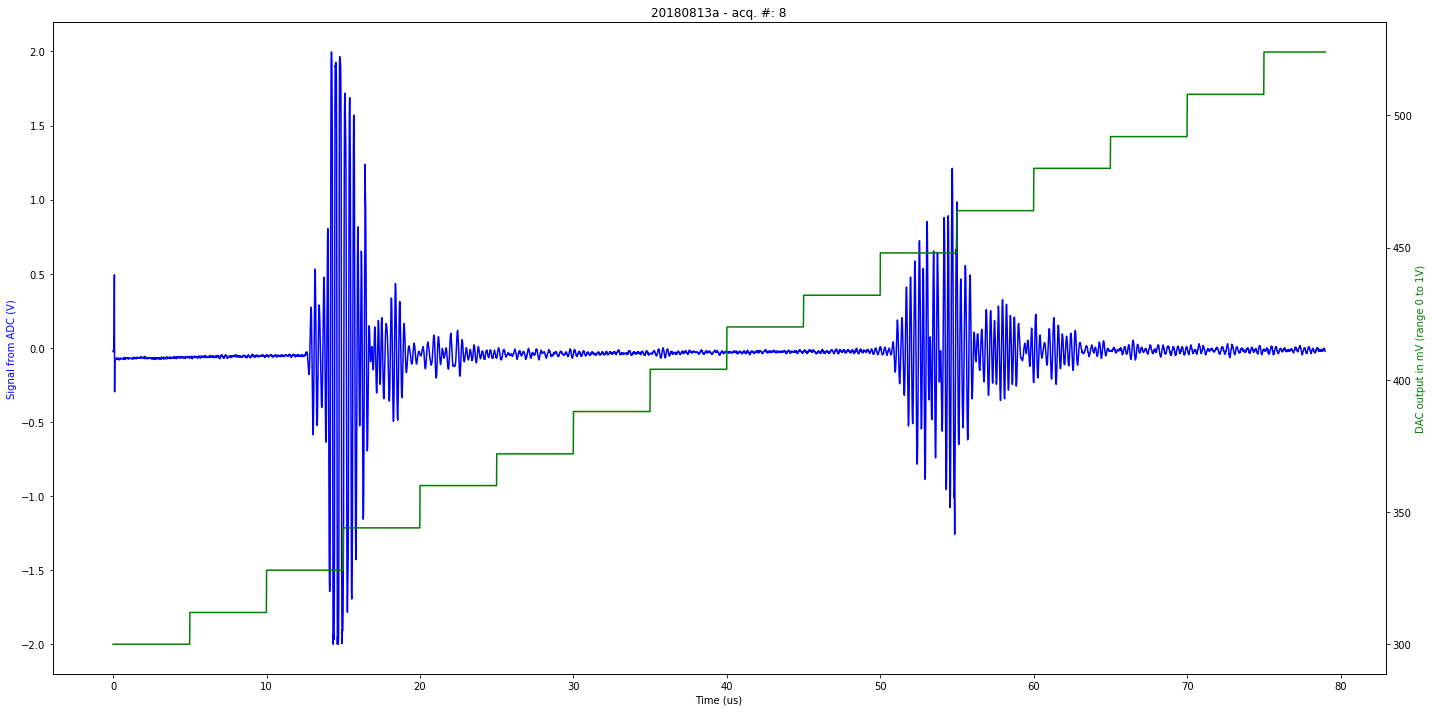

In [2]:
x = us_json()
x.JSONprocessing("data/20180813a-9.json")
print x.Registers["228"]
y = us_json()
y.JSONprocessing("data/20180813a-8.json")
print y.Registers["228"]
y.mkImg()

# Plotting the two series

with "wrong" t scale.

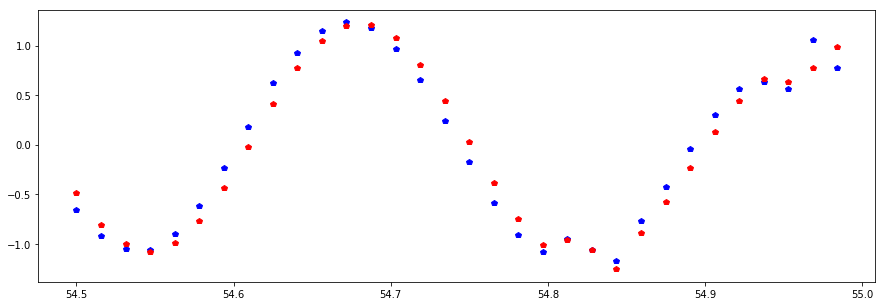

In [3]:
A = 54*64+32
B = 55*64
plt.figure(figsize=(15,5))
plt.plot(x.t[A:B],x.tmp[A:B],"bp")
plt.plot(y.t[A:B],y.tmp[A:B],"rp")
plt.show()

# Now, let's readjust the time axis to consider the 1/2 phase offset

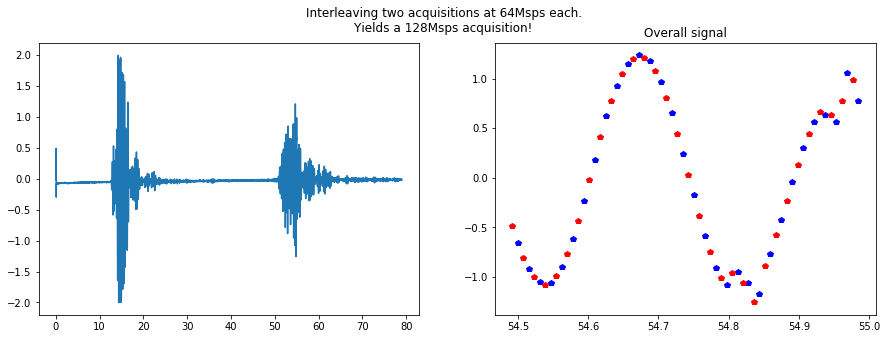

In [4]:
NewT = [k -1.0/128 for k in x.t[A:B]]
A = 54*64+32
B = 55*64

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(x.t,y.tmp)
plt.suptitle ("Interleaving two acquisitions at 64Msps each.\nYields a 128Msps acquisition!")
ax2.set_title('Interleaving')
ax2.set_title('Overall signal')
ax2.plot(x.t[A:B],x.tmp[A:B],"bp")
ax2.plot(NewT,y.tmp[A:B],"rp")
FileName = "128Msps_"+x.iD+"-"+str(x.N)+"-detail.jpg"
plt.savefig(FileName)
plt.show() 

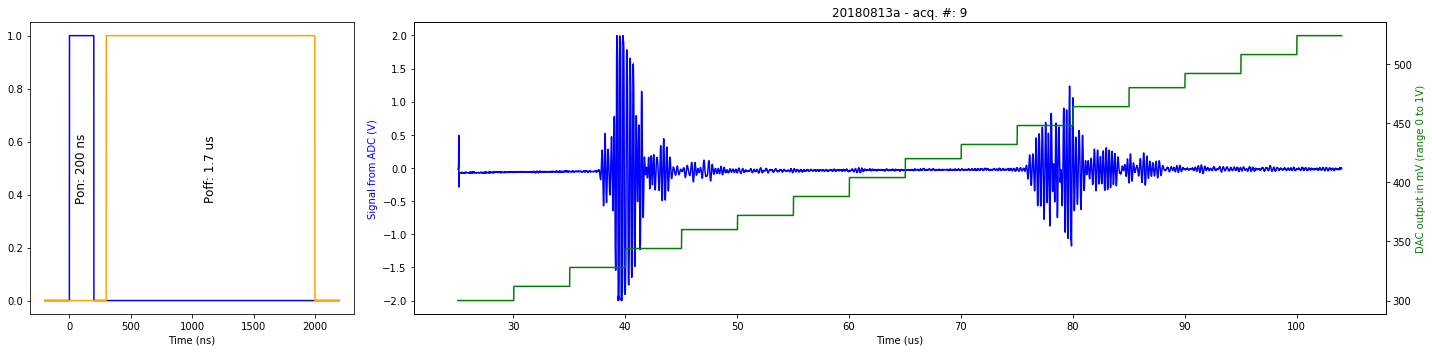

In [90]:
def makeImg(x):
    
    RangeP = range(x.timings['t3']+2*x.timings['t1'])
    
    T = [ t-x.timings['t1'] for t in RangeP ]
    PON = [ k for k in RangeP   ]
    
    fig, (ax3, ax1)= plt.subplots(1,2,gridspec_kw = {'width_ratios':[1, 3]},figsize=(20,5) )
    ax2 = ax1.twinx() 
    
    x.T4 = [ m + x.timings['t4']/1000.0 for m in x.t ]
    
    ax2.plot(x.T4[0:x.len_line], x.tdac[0:x.len_line], 'g-')
    ax1.plot(x.T4[0:x.len_line], x.tmp[0:x.len_line], 'b-')
    plt.title( x.iD + " - acq. #: "+ str(x.N))
    ax1.set_xlabel('Time (us)')
    ax1.set_ylabel('Signal from ADC (V)', color='b')
    ax2.set_ylabel('DAC output in mV (range 0 to 1V)', color='g')
                                  
    LEN = x.timings['t3']+2*x.timings['t1']
    RangeP = range(LEN)
    T = [ t - x.timings['t1'] for t in RangeP ]
    PON = np.zeros(LEN)
    POFF = np.zeros(LEN)

    for k in RangeP:
        if T[k] > 0 and T[k] < x.timings['t1']:
            PON[k] = 1
        if T[k] > (x.timings['t2']+x.timings['t1']) and T[k] < x.timings['t3']:
            POFF[k] = 1

    ax3.plot(T,PON,"b") 
    ax3.text(x.timings['t1']/2, 0.5, "Pon: "+str(x.timings['t1'])+" ns", rotation='vertical', horizontalalignment='center', verticalalignment='center',fontsize=12)
    ax3.plot(T,POFF,"orange") 
    ax3.text((x.timings['t3'] +x.timings['t2']+x.timings['t1'] )/2, 0.5, "Poff: "+str((x.timings['t3']-x.timings['t2']-x.timings['t1'])/1000.0)+" us",         horizontalalignment='center',
            verticalalignment='center',rotation='vertical',fontsize=12)
    ax3.set_xlabel('Time (ns)')                                
    plt.tight_layout()
    FileName = "images/"+x.iD+"-"+str(x.N)+".jpg"
    #plt.savefig(FileName)
    plt.show() 
    #x.TagImage("matty,cletus",x.iD,"graph","Graph of "+x.iD +" experiment. "+x.experiment["description"])

makeImg(x)

In [73]:
p = (x.timings['t3'] -x.timings['t2']-x.timings['t1'] )/2
print p

850


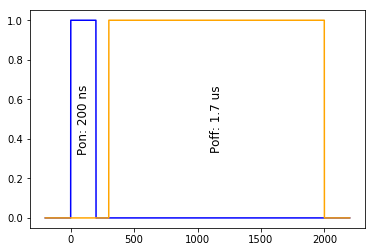

In [84]:

plt.show()


In [30]:
x.timings['t4']

{u'Fech': 64.0,
 u'LAcq': 79,
 u'NAcq': 5056,
 u'NLines': 1,
 u't1': 200,
 u't2': 100,
 u't3': 2000,
 u't4': 25040,
 u't5': 105000}